In [1]:
from base import *
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
import time

In [2]:
LIAR = Dataset('./liar_dataset')

TEXT_TRAIN = LIAR.train['statement'] 
TEXT_TEST = LIAR.test['statement']

text_train = TEXT_TRAIN.apply(text_preprocess)
text_test = TEXT_TEST.apply(text_preprocess)

tfidf = TfidfVectorizer()
data_train = tfidf.fit_transform(text_train)
data_test = tfidf.transform(text_test)


## Proposed method

In [3]:
class ProposedMethod():
    def __init__(self):

        self.prediction = None
        self.fuzzifers = [Fuzzifier() for i in range(4)]
        self.final_model = XGBClassifier(
                                n_estimators = 100,
                                objective = 'multi:softmax',
                                learning_rate = .01,
                                max_depth = 8)
        
        self.text_models = [
            XGBClassifier(
                n_estimators = 100,
                learning_rate = .3,
                max_depth = 2),

            XGBClassifier(
                n_estimators = 50,
                learning_rate = .3,
                max_depth = 2),

            XGBClassifier(
                n_estimators = 50,
                learning_rate = .1,
                max_depth = 2),

            XGBClassifier(
                n_estimators = 100,
                learning_rate = .3,
                max_depth = 2),
        ]

        self.final_map = {
            'pants-fire'  : 0, 
            'false'       : 1, 
            'barely-true' : 2, 
            'half-true'   : 3, 
            'mostly-true' : 4, 
            'true'        : 5
        }
        
        self.maps = [
            {
                'pants-fire'  : 0, 
                'false'       : 0, 
                'barely-true' : 1, 
                'half-true'   : 1, 
                'mostly-true' : 1, 
                'true'        : 1
            },
            {
                'pants-fire'  : 0, 
                'false'       : 0, 
                'barely-true' : 1, 
                'half-true'   : 1, 
                'mostly-true' : 0, 
                'true'        : 0
            },
            {
                'pants-fire'  : 0, 
                'false'       : 0, 
                'barely-true' : 0, 
                'half-true'   : 0, 
                'mostly-true' : 1, 
                'true'        : 1
            },
            {
                'pants-fire'  : 0, 
                'false'       : 0, 
                'barely-true' : 0, 
                'half-true'   : 1, 
                'mostly-true' : 1, 
                'true'        : 1
            }
        ]
        self.delabel = {
            0 : 'pants-fire', 
            1 : 'false'     ,
            2 : 'barely-true',
            3 : 'half-true'  ,
            4 : 'mostly-true',
            5 : 'true'
        }
        self.scaler = MinMaxScaler()
        
    def fit_(self, X, y):
        base_preds = np.empty((y.shape[0], 4))
        self.centroids = []
        for i in range(4):
            start = time.time()
            y_ = y.map(self.maps[i])
            self.fuzzifers[i].fit(X, y_, 2)
            X_ = self.fuzzifers[i].predict(X)
            self.text_models[i].fit(X_, y_)
            base_preds[:, i] = self.text_models[i].predict_proba(X_)[:, 0]
            end = time.time()
            execution_time = end - start
            print(f'Model {i+1}:')
            print(f'accuracy: {accuracy_score(y_, self.text_models[i].predict(X_))*100:.2f} %')
            print(f'execution time: {execution_time:.2f}s')

        start = time.time()
        y_ = y.map(self.final_map)
        X_ = base_preds
        X_ = self.scaler.fit_transform(X_)
        self.final_model.fit(X_, y_)
        end = time.time()
        execution_time = end - start
        print('-'*60)
        print('Final model:')
        print(f'accuracy: {accuracy_score(y_, self.final_model.predict(X_))*100:.2f} %')
        print(f'execution time: {execution_time:.2f}s')

    def predict_(self, X, y):
        base_preds = np.empty((y.shape[0], 4))
        for i in range(4):
            start = time.time()
            y_ = y.map(self.maps[i])
            X_ = self.fuzzifers[i].predict(X)
            base_preds[:, i] = self.text_models[i].predict_proba(X_)[:, 0]
            end = time.time()
            execution_time = end - start
            print(f'Model {i}:')
            print(f'accuracy: {accuracy_score(y_, self.text_models[i].predict(X_))*100:.2f} %')
            print(f'execution time: {execution_time:.2f}s')
        
        start = time.time()
        y_ = y.map(self.final_map)
        X_ = base_preds
        X_ = self.scaler.transform(X_)
        self.prediction = self.final_model.predict(X_)
        end = time.time()
        execution_time = end - start
        print('-'*60)
        print('Final model:')
        print(f'accuracy: {accuracy_score(y_, self.prediction)*100:.2f} %')
        print(f'execution time: {execution_time:.2f}s')
        return self.prediction

        
    def fit(self, X, y):
        base_preds = np.empty((y.shape[0], 4))
        self.centroids = []
        for i in range(4):
            y_ = y.map(self.maps[i])
            self.fuzzifers[i].fit(X, y_, 2)
            X_ = self.fuzzifers[i].predict(X)
            self.text_models[i].fit(X_, y_)
            base_preds[:, i] = self.text_models[i].predict_proba(X_)[:, 0]
       
        y_ = y.map(self.final_map)
        X_ = base_preds
        X_ = self.scaler.fit_transform(X_)
        self.final_model.fit(X_, y_)

    def predict(self, X):
        base_preds = np.empty((X.shape[0], 4))
        for i in range(4):
            X_ = self.fuzzifers[i].predict(X)
            base_preds[:, i] = self.text_models[i].predict_proba(X_)[:, 0]
            
        X_ = base_preds
        X_ = self.scaler.transform(X_)
        self.prediction = self.final_model.predict(X_)
        return [self.delabel[x] for x in self.prediction]

In [4]:
clf = ProposedMethod()
start = time.time()
clf.fit(data_train, LIAR.y_train)
end = time.time()
execution_time = end - start
print(f'Model training time: {execution_time:.2f}s')

Model training time: 7.07s


In [5]:
print('Details on training Phase')
clf.fit_(data_train, LIAR.y_train)
print()
print('Details on testing Phase')
print('='*60)
pred = clf.predict_(data_test, LIAR.y_test)

Details on training Phase
Model 1:
accuracy: 74.02 %
execution time: 1.65s
Model 2:
accuracy: 67.84 %
execution time: 1.58s
Model 3:
accuracy: 68.74 %
execution time: 1.65s
Model 4:
accuracy: 66.91 %
execution time: 1.76s
------------------------------------------------------------
Final model:
accuracy: 47.72 %
execution time: 1.23s

Details on testing Phase
Model 0:
accuracy: 68.82 %
execution time: 0.27s
Model 1:
accuracy: 60.02 %
execution time: 0.24s
Model 2:
accuracy: 63.06 %
execution time: 0.24s
Model 3:
accuracy: 60.80 %
execution time: 0.24s
------------------------------------------------------------
Final model:
accuracy: 26.97 %
execution time: 0.01s


In [6]:
pred = clf.predict(data_test)
print(classification_report(LIAR.y_test, pred))

              precision    recall  f1-score   support

 barely-true       0.25      0.24      0.25       214
       false       0.26      0.32      0.29       250
   half-true       0.29      0.35      0.32       267
 mostly-true       0.31      0.33      0.32       249
  pants-fire       0.29      0.08      0.12        92
        true       0.21      0.15      0.17       211

    accuracy                           0.27      1283
   macro avg       0.27      0.24      0.24      1283
weighted avg       0.27      0.27      0.26      1283



<Figure size 1000x700 with 0 Axes>

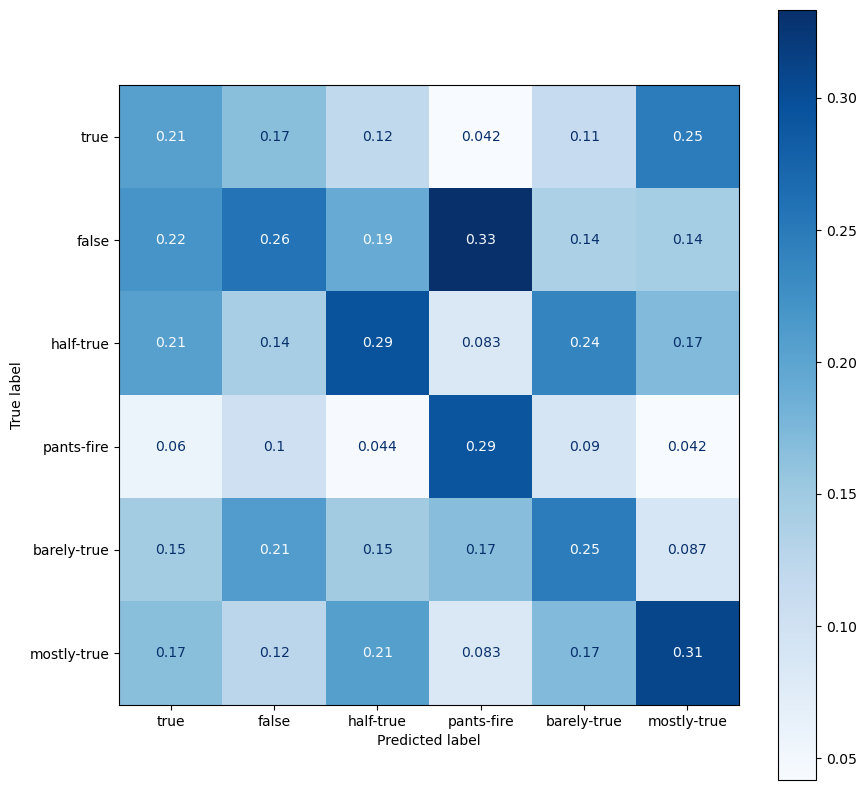

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

cm = confusion_matrix(LIAR.y_test, pred, labels= LIAR.y_test.unique(), normalize='pred')
cmp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=LIAR.y_test.unique())
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(cmap = 'Blues', ax=ax);
